In [1]:
##############################################################################
# Clustering by fast search and find of density peaks version 2
# Charles AHAMED 
# ISEP A3 60488
##############################################################################

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn import datasets


# Implémentation python

In [3]:
def density_peaks_clustering(data, dc):
    n = len(data)
    distances = np.zeros((n, n))
    
    # Calcul de la distance entre les points
    for i in range(n):
        for j in range(n):
            if i != j:
                distances[i, j] = np.linalg.norm(data[i] - data[j])
                distances[j, i] = distances[i, j]
    
    d_loc = np.zeros(n)
    d_min = np.zeros(n)
       
    # Calcul de la densité locale (d_loc) pour chaque point
    for i in range(n):
        for j in range(n):
            if i != j:
                d_loc[i] += np.exp(-(distances[i, j] / dc) ** 2) 

    # le point avec la plus haute densité
    max_d_loc = max(d_loc)
    nearest_higher_density_point = np.zeros(n, dtype=int)
    # calculer la distance minimale avec le point de densité supérieure le plus proche ( exception pour max_d_loc ou l'on
    # calcule la distance maximale )
    for i in range(n):
        min_distance = float('inf')
        if d_loc[i] == max_d_loc:
            for j in range(n):
                if i != j :
                    d_min[i] = np.max(distances[i,j])  # pour le point de plus haute densité on attribue d_min = d_max
                    indice_max= j
                    nearest_higher_density_point[i] = j
        else:
            for j in range(n):
                if i != j and d_loc[j] > d_loc[i]:
                    if distances[i, j] < min_distance:
                        min_distance = distances[i, j]
                        nearest_higher_density_point[i] = j
            d_min[i] = min_distance
            
    d_min[indice_max] = np.max(d_min) 
            
    # Plot epsilon = d_loc * d_min
    epsilon = d_loc * d_min
    sorted_indices = np.argsort(epsilon)[::-1]  # classer les indices par ordre décroissant
    sorted_e = epsilon[sorted_indices]  # classer les valeurs de epsilon aussi
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, n + 1), sorted_e, marker='o')
    plt.xlabel('n')
    plt.ylabel('epsilon = d_loc * d_min (classé)')
    plt.title('Plot of epsilon = d_loc * d_min (classé par ordre décroissant)')
    plt.grid(True)
    plt.show()
    
    #Plot d_min en fonction de d_loc
    plt.scatter(d_loc, d_min, marker='o', alpha=0.5)
    plt.xlabel('Densité locale (d_loc)')
    plt.ylabel('Distance avec les points de densité max (d_min)')
    plt.title('Graphique de decision')
    
    #Les centres de clusters seront selectionnés parmis les points ayant une densité locale très elevée
    x_lim = plt.xlim() 
    d_loc_threshold = x_lim[1]/2.2
    print("d_loc_threshold",d_loc_threshold)
    
    #les centres de clusters seront selectionnées parmis les points ayant une distance minimale elevée
    #cependant ce critère a moins d'importance que celui de la densité locale donc on est un peu plus souple et on divise
    #par un plus grand nombre la valeur maximale
    y_lim = plt.ylim() 
    d_min_threshold = y_lim[1]/2.6
    print("d_min_threshold",d_min_threshold)
    
   # Identifier les centre de clusters a l'aide du graphique de decision on choisi le treshold adapté pour d_min               
    cluster_centers = []
    for i in range(n):
        if d_loc[i] >= d_loc_threshold:
            if d_min[i] >= d_min_threshold:
                cluster_centers.append(i)
                #print("d_loc=", d_loc[i], "d_min=", d_min[i])
                
    # Affichage ldes centres de cluster en rouge
    plt.scatter([d_loc[i] for i in cluster_centers], [d_min[i] for i in cluster_centers], c='red')
    plt.show()
    print(cluster_centers)
    
    cluster_centers_with_labels = [(center_idx, cluster_num) for cluster_num, center_idx in enumerate(cluster_centers)]  
   
    #Assignation des centres de clusters a un cluster
    label_results = [-1] * n # liste pour stocker numéro de cluster attribué a chaque point 
    for i, point_i in enumerate(sorted_indices):
        closest_j = None
        min_distance = float('inf')
        for center_idx, cluster_num in cluster_centers_with_labels:
            if i == center_idx:
                closest_j = cluster_num + 1
                #print("clusternum",closest_j)      
        if closest_j is not None:
            label_results[i] = closest_j
            #print("TEST",i)
            #print("point_j",closest_j)

    #Assignation des autres points s
    sorted_indices = list(range(len(d_loc)))
    sorted_indices.sort(key=lambda i: d_loc[i], reverse=True) # on classe les points par ordre de densité locale décroissante
    #print(sorted_indices)
    for i in range(len(sorted_indices)):
        if label_results[sorted_indices[i]] != center_idx and label_results[sorted_indices[i]] == -1 :
            label_results[sorted_indices[i]] = label_results[nearest_higher_density_point[sorted_indices[i]]] 
            # attribution de chaque points au meme cluster que son voisin de densité supérieure le plus proche
    
    print(label_results)
    
    # Affichage des clusters avec une couleur différente, il faudra ajouter des couleurs si k > 7
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    unique_clusters = np.unique(label_results)
    for i, cluster_num in enumerate(unique_clusters):
        color = colors[i % len(colors)]
        cluster_indices = np.where(np.array(label_results) == cluster_num)[0]
        cluster_points = data[cluster_indices]  
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=color, label=f'Cluster {cluster_num}')
    
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('my data distribution')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return label_results
    

# Demonstration sur des jeux de données en 2D

787 samples and 3 features:
   15.55  28.65  2
0  14.90  27.55  2
1  14.45  28.35  2
2  14.15  28.80  2
3  13.75  28.05  2
4  13.35  28.45  2


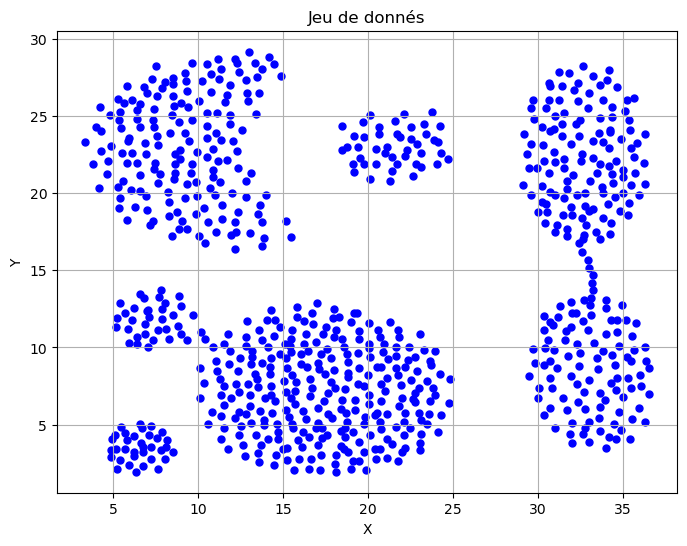

In [4]:
df = pd.read_csv("Aggregation.txt",sep='\t')
nb_samples, nb_features = df.shape
print("{0} samples and {1} features:".format(nb_samples, nb_features))
print(df[:5])

labels=df.iloc[:, 2]
labels=labels.tolist()

#print("labels",labels)

df = df.drop(df.columns[2], axis=1)


data1 = df.values

#print(data1)
dc = 1.5

plt.figure(figsize=(8, 6))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], marker='o', c='b', s=25)
plt.title("Jeu de donnés")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


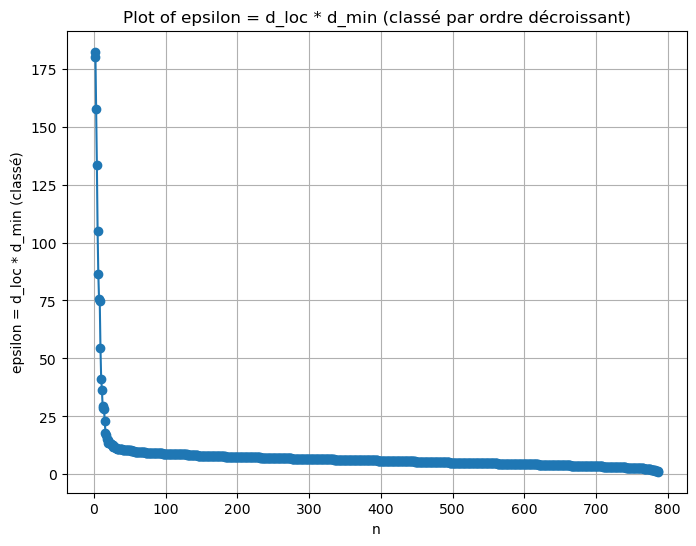

d_loc_threshold 7.501385663447217
d_min_threshold 5.697841905590568


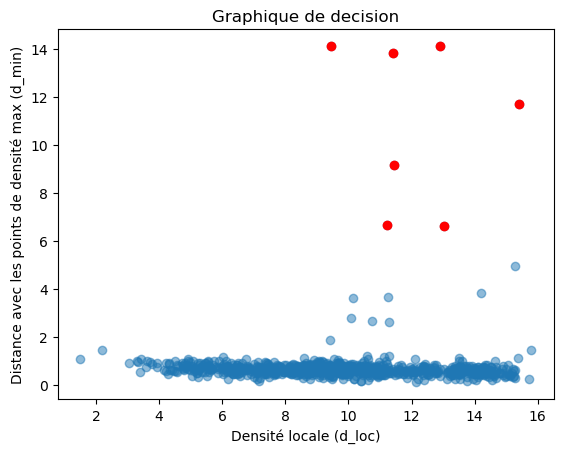

[44, 189, 340, 551, 602, 742, 786]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

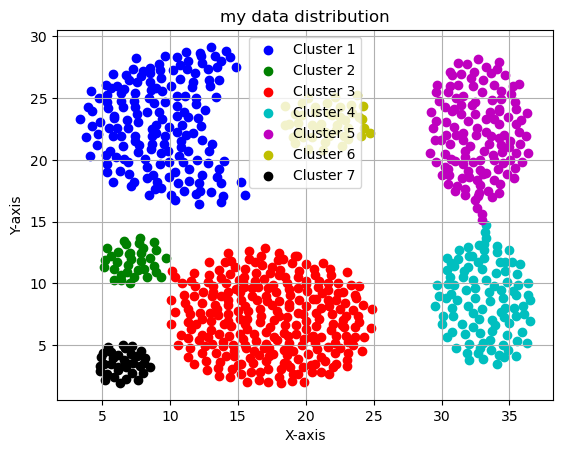

In [5]:
label_results = density_peaks_clustering(data1, dc)

In [6]:

confusion_matrix = pd.crosstab(labels, label_results, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)


score = silhouette_score(data1, label_results, metric='euclidean')
print('Silhouetter Score: %.3f' % score)


Predicted    1   2    3    4    5   6   7
Actual                                   
1            0   0    0    0    0  45   0
2          169   0    0    0    0   0   0
3            0   0    0  102    0   0   0
4            0   0  273    0    0   0   0
5            0   0    0    0    0   0  34
6            0   0    0    1  129   0   0
7            0  34    0    0    0   0   0
Silhouetter Score: 0.494


239 samples and 3 features:
   1.85   27.8  1
0  1.35  26.65  1
1  1.40  23.25  2
2  0.85  23.05  2
3  0.50  22.35  2
4  0.65  21.35  2


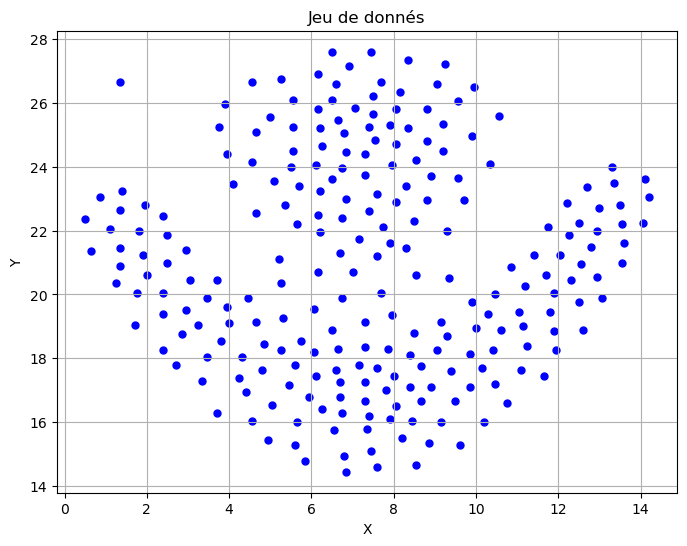

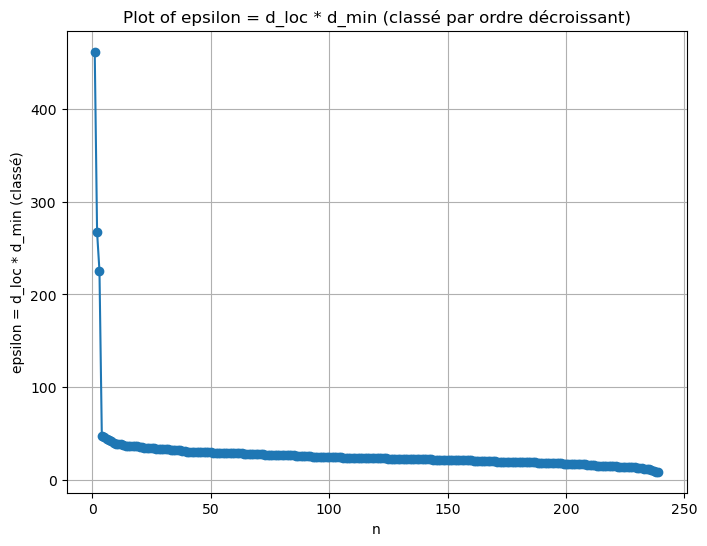

d_loc_threshold 25.416747016950335
d_min_threshold 3.476225578950887


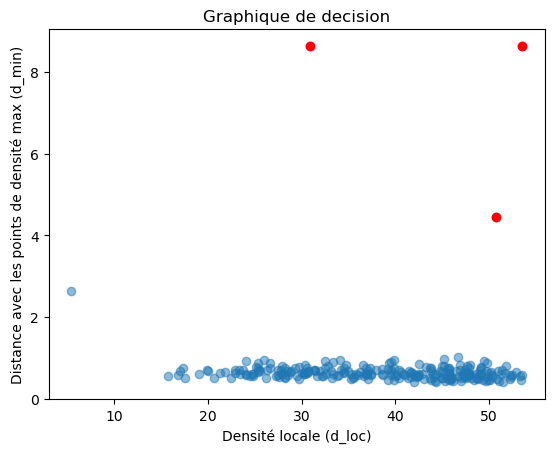

[62, 187, 238]
[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3]


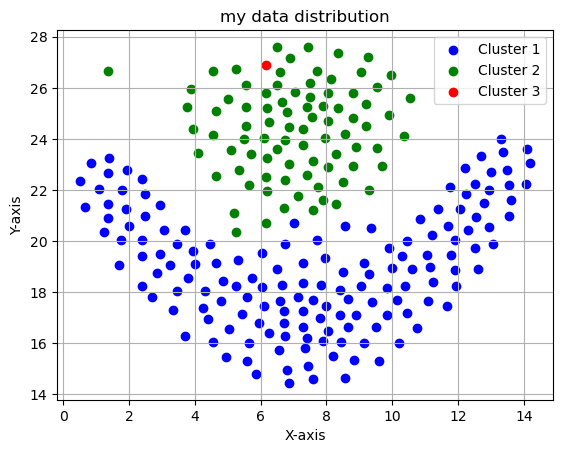

In [7]:
df2 = pd.read_csv("flame.txt",sep='\t')
nb_samples, nb_features = df2.shape
print("{0} samples and {1} features:".format(nb_samples, nb_features))
print(df2[:5])
labels2=df2.iloc[:, 2]
labels2=labels2.tolist()
df2 = df2.drop(df2.columns[2], axis=1)
data2 = df2.values
dc = 3

plt.figure(figsize=(8, 6))
plt.scatter(df2.iloc[:, 0], df2.iloc[:, 1], marker='o', c='b', s=25)
plt.title("Jeu de donnés")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

label_results2 = density_peaks_clustering(data2, dc)

In [8]:


confusion_matrix = pd.crosstab(labels2, label_results2, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

score = silhouette_score(data2, label_results2, metric='euclidean')
print('Silhouetter Score: %.3f' % score)

Predicted    1   2  3
Actual               
1            3  82  1
2          151   2  0
Silhouetter Score: 0.132


311 samples and 3 features:
   31.95  7.95  3
0  31.15  7.30  3
1  30.45  6.65  3
2  29.70  6.00  3
3  28.90  5.55  3
4  28.05  5.00  3


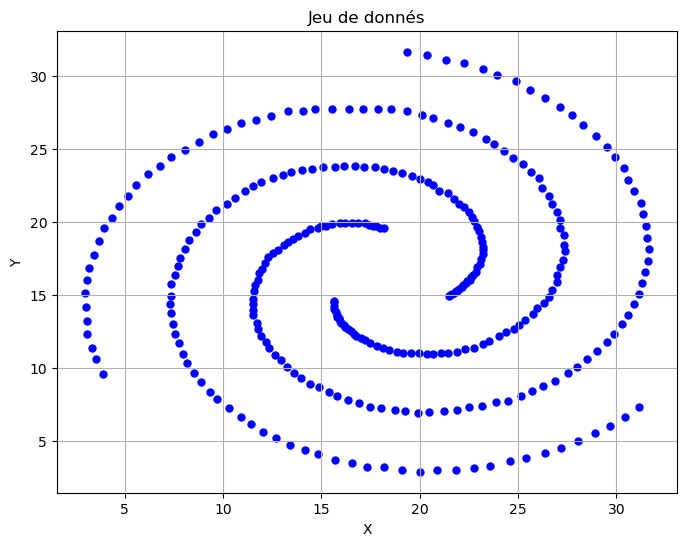

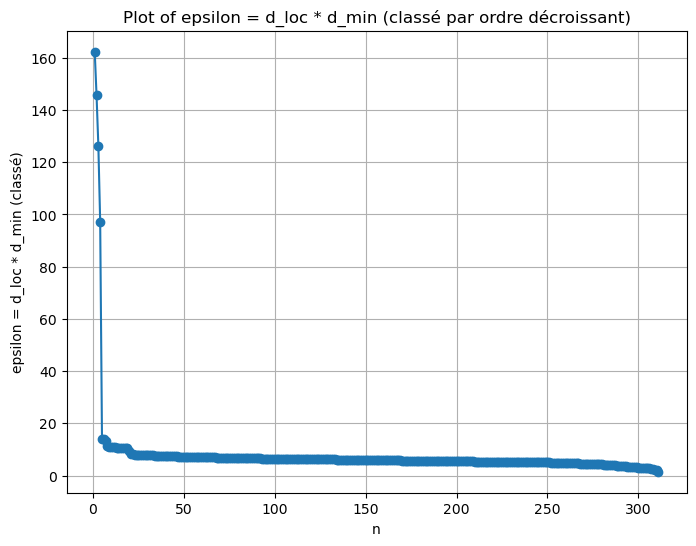

d_loc_threshold 10.57497672455628
d_min_threshold 2.937089289440021


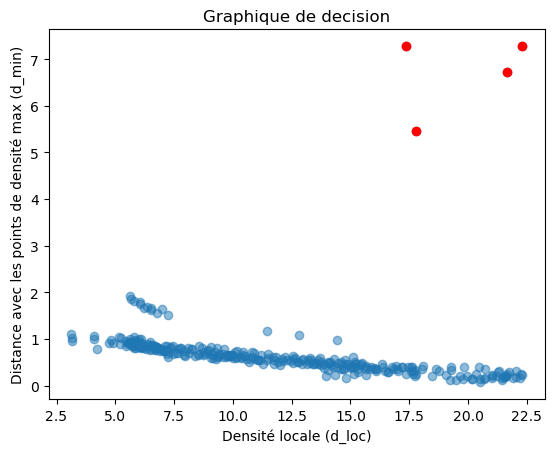

[91, 194, 297, 310]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4]


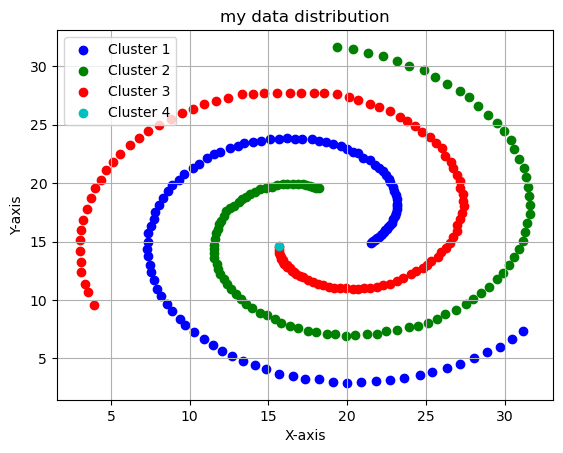

In [9]:
df3 = pd.read_csv("spiral.txt",sep='\t')
nb_samples, nb_features = df3.shape
print("{0} samples and {1} features:".format(nb_samples, nb_features))
print(df3[:5])
labels3=df3.iloc[:, 2]
labels3=labels3.tolist()
#print("labels",labels)
df3 = df3.drop(df3.columns[2], axis=1)
data3 = df3.values
dc = 3


plt.figure(figsize=(8, 6))
plt.scatter(df3.iloc[:, 0], df3.iloc[:, 1], marker='o', c='b', s=25)
plt.title("Jeu de donnés")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


label_results3 = density_peaks_clustering(data3, dc)

In [10]:


confusion_matrix = pd.crosstab(labels3, label_results3, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

score = silhouette_score(data3, label_results3, metric='euclidean')
print('Silhouetter Score: %.3f' % score)

Predicted    1    2    3  4
Actual                     
1            0  101    0  0
2            0    0  104  1
3          105    0    0  0
Silhouetter Score: -0.258
